## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN


## Reading in Barcelona Data

In [2]:
barca = pd.read_csv('../open-data/data/teams/Barcelona_data.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (22,28,32,33,34,36,39,40,43,44,63,64,65,68,70,71,72,73,74,76,88,89,91,92,94,96,98,101,114,115,116,120,123,124,125,126,127,128,129,131,137,138,139,140,141,143,144,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
barca.shape

(874826, 149)

## Cleaning Barcelona Data

We will first create a check list of columns I need to check. These are the columns that the warning above is mentioning. We should have done this in the first notebook but due to time constraints, we will only do it here. If there is time, I will address this problem in the previous notebook in order to prevent the same warning every time we import a particular team data csv file.

In [4]:
cols = list(barca.columns)
index_to_check = [22,28,32,33,34,36,39,40,43,44,63,
                  64,65,68,70,71,72,73,74,76,88,89,
                  91,92,94,96,98,101,114,115,116,120,
                  123,124,125,126,127,128,129,131,137,
                  138,139,140,141,143,144,146,147,148]

We will get the name of the columns that were referenced by the warning into a list called `mixed_cols`

In [5]:
mixed_cols = []
for index in index_to_check:
    mixed_cols.append(cols[index])

Lets take a look at what the columns look like:

In [6]:
barca[mixed_cols].T

,0,1,2,3,4,5,6,7,8,9,...,874816,874817,874818,874819,874820,874821,874822,874823,874824,874825
tactics_lineup,"[{'player': {'id': 20055, 'name': 'Marc-André ...","[{'player': {'id': 6792, 'name': 'Pau López Sa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_deflected,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_aerial_won,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_no_touch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_miscommunication,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_straight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_cut_back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_inswinging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_outswinging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pass_goal_assist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
barca[barca['shot_deflected'].isna()== True]['shot_deflected'].value_counts()

Series([], Name: shot_deflected, dtype: int64)

In [8]:
barca[barca['shot_deflected'].isna()== False]['shot_deflected'].value_counts()

True    58
Name: shot_deflected, dtype: int64

After checking in with the data dictionary, we will narrow down our columns. We will not need any IDs except for the row `id` because every time there is an id for a specific column, there is also a name for that exact column. The redundance of information does not help. 

In [9]:
barca.drop(columns= barca.columns[barca.columns.str.contains('_id')], inplace = True)
barca

,id,index,period,timestamp,minute,second,possession,duration,related_events,location,...,injury_stoppage_in_chain,block_save_block,block_offensive,block_deflection,bad_behaviour_card_name,miscontrol_aerial_won,50_50_outcome_name,half_start_late_video_start,half_end_early_video_end,player_off_permanent
0,1f871f31-7a38-4e3d-a936-cf2397e921f7,1,1,2019-12-02 00:00:00.000,0,0,1,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58cbfd8f-7f5d-4ca3-a0cc-e0610f2a2a14,2,1,2019-12-02 00:00:00.000,0,0,1,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b48b3dee-38d6-4682-93a9-5e06514d015c,3,1,2019-12-02 00:00:00.000,0,0,1,0.000000,['7d4e60fb-0dac-4a2f-b47a-f7237024cbc8'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7d4e60fb-0dac-4a2f-b47a-f7237024cbc8,4,1,2019-12-02 00:00:00.000,0,0,1,0.000000,['b48b3dee-38d6-4682-93a9-5e06514d015c'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e97ecc5e-c15f-47af-8d3b-32af0c55ef3a,9,1,2019-12-02 00:00:06.083,0,6,3,2.806400,"['7efa37aa-4772-45d4-812b-2bbf5e16f597', 'c485...","[56.1, 6.5]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874821,22d2b55b-66ef-4421-bd19-154a3ace5f41,4383,2,2019-12-02 00:47:55.026,92,55,195,0.751641,['842f45a4-6d61-42dd-834e-5a6ba3dc2b21'],"[64.4, 80.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874822,805e24ee-a42a-46b3-8e27-c9daa086a927,4384,2,2019-12-02 00:47:55.597,92,55,195,0.936300,['842f45a4-6d61-42dd-834e-5a6ba3dc2b21'],"[49.5, 6.9]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874823,842f45a4-6d61-42dd-834e-5a6ba3dc2b21,4385,2,2019-12-02 00:47:55.777,92,55,195,NaN,"['22d2b55b-66ef-4421-bd19-154a3ace5f41', '805e...","[70.2, 76.9]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874824,b1de7d59-fecb-4292-bfa3-924307bd6e61,4386,2,2019-12-02 00:47:58.567,92,58,195,0.000000,['ae72a70a-d45a-40ce-87ef-e7835aa160df'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that we have remaining name columns, we can focus on imputing `NaN` values for each column. Since the expected values in this columns are string names, we will replace `NaN` values with the `'Not Applicable` in order for us to know that the row does not have any associated name to it. We will also remove the colums that were filled with `Not Applicable`, from our `mixed_cols` list if they exist in the list 

In [10]:
name_cols = list(barca.columns[barca.columns.str.contains('_name')])

In [11]:
for name in name_cols:
    barca[name].fillna('Not Applicable', inplace = True)
    if name in mixed_cols:
        mixed_cols.remove(name)
mixed_cols

['tactics_lineup',
 'pass_deflected',
 'pass_aerial_won',
 'pass_no_touch',
 'pass_miscommunication',
 'pass_straight',
 'pass_cut_back',
 'pass_inswinging',
 'pass_outswinging',
 'pass_goal_assist',
 'dribble_overrun',
 'dribble_nutmeg',
 'dribble_no_touch',
 'goalkeeper_success_in_play',
 'goalkeeper_success_out',
 'goalkeeper_shot_saved_to_post',
 'goalkeeper_punched_out',
 'goalkeeper_lost_out',
 'goalkeeper_lost_in_play',
 'goalkeeper_shot_saved_off_target',
 'shot_one_on_one',
 'shot_deflected',
 'shot_follows_dribble',
 'shot_open_goal',
 'shot_saved_to_post',
 'shot_aerial_won',
 'shot_redirect',
 'shot_saved_off_target',
 'ball_recovery_recovery_failure',
 'ball_recovery_offensive',
 'clearance_other',
 'clearance_aerial_won',
 'foul_won_penalty',
 'foul_won_advantage',
 'foul_won_defensive',
 'foul_committed_offensive',
 'foul_committed_penalty',
 'foul_committed_advantage',
 'injury_stoppage_in_chain',
 'block_save_block',
 'block_offensive',
 'block_deflection',
 'miscontro

We will remove `tactice_lineup` from our `mixed_cols` list since this is not a boolean column 

In [12]:
mixed_cols.remove('tactics_lineup')

Now that we have narrowed down our `mixed_cols` list to only boolean columns, we can replace any `NaN` values or empty strings with 0 and `True` with 1 

In [13]:
for col in mixed_cols:
    barca[col] = barca[col].map({True: 1, np.nan:0, '':0 })

In [14]:
remaining_cols = [col for col in  barca if len(barca[barca[col].isna()]) > 0]
remaining_cols

['duration',
 'related_events',
 'location',
 'under_pressure',
 'counterpress',
 'off_camera',
 'out',
 'tactics_lineup',
 'tactics_formation',
 'pass_switch',
 'pass_shot_assist',
 'pass_cross',
 'pass_length',
 'pass_through_ball',
 'pass_end_location',
 'pass_angle',
 'pass_backheel',
 'carry_end_location',
 'goalkeeper_end_location',
 'goalkeeper_penalty_saved_to_post',
 'goalkeeper_saved_to_post',
 'shot_statsbomb_xg',
 'shot_end_location',
 'shot_kick_off',
 'shot_freeze_frame',
 'shot_first_time',
 'clearance_left_foot',
 'clearance_head',
 'clearance_right_foot']

Notice that some of these columns, some of these columns are also boolean columns but were not part of the warnings in the import.

In [15]:
barca[barca['duration'].isna()== True]['duration'].value_counts

<bound method IndexOpsMixin.value_counts of 5        NaN
8        NaN
12       NaN
15       NaN
18       NaN
          ..
874811   NaN
874814   NaN
874817   NaN
874820   NaN
874823   NaN
Name: duration, Length: 233660, dtype: float64>

In [16]:
barca[barca['duration'].isna()== False]['duration'].value_counts

<bound method IndexOpsMixin.value_counts of 0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         2.806400
            ...   
874819    0.406100
874821    0.751641
874822    0.936300
874824    0.000000
874825    0.000000
Name: duration, Length: 641166, dtype: float64>

Lets tackle the boolean columns first since we know how to appraoch these columns from before

In [17]:
boolean_cols =[ 'under_pressure', 'counterpress', 'off_camera', 'out','pass_switch', 
                'pass_shot_assist', 'pass_cross', 'pass_backheel', 'goalkeeper_penalty_saved_to_post',
                'goalkeeper_saved_to_post','shot_first_time','shot_kick_off','shot_freeze_frame',
                'clearance_left_foot','clearance_right_foot','clearance_head' ]
for col in boolean_cols:
    barca[col] = barca[col].map({True: 1, np.nan:0, '':0 })
    if col in remaining_cols:
        remaining_cols.remove(col)

In [18]:
remaining_cols

['duration',
 'related_events',
 'location',
 'tactics_lineup',
 'tactics_formation',
 'pass_length',
 'pass_through_ball',
 'pass_end_location',
 'pass_angle',
 'carry_end_location',
 'goalkeeper_end_location',
 'shot_statsbomb_xg',
 'shot_end_location']

According to out data dictionary, `through_ball` variable for passes is now depracted so we will remove them from our dataframe

In [19]:
barca.drop(columns= ['pass_through_ball'], inplace = True)
remaining_cols.remove('pass_through_ball')
remaining_cols

['duration',
 'related_events',
 'location',
 'tactics_lineup',
 'tactics_formation',
 'pass_length',
 'pass_end_location',
 'pass_angle',
 'carry_end_location',
 'goalkeeper_end_location',
 'shot_statsbomb_xg',
 'shot_end_location']

In [20]:
loc_col = []
for name in remaining_cols:
    if 'location' in name:
        loc_col.append(name)

In [21]:
for loc in loc_col:
    barca[loc].fillna('[-1,-1]', inplace = True)
    if loc in remaining_cols:
        remaining_cols.remove(loc)

For the time beaing, everything else will be assigned to 0 if there is a null value. I am short on time but will review this when I have more time

In [22]:
for col in remaining_cols:
    barca[col] = barca[col].map({ np.nan:0, '':0 })

## Visualization

In [23]:
#CREDIT TO GITHUB USERNAME: tuangauss 
#for creating a function to generate a soccer_pitch 
#https://github.com/tuangauss/DataScienceProjects/blob/master/Python/football_visual.ipynb

def draw_pitch(ax):
    # size of the pitch is 120, 80
    #Create figure

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([14.6,14.6],[57.8,22.2],color="black")
    plt.plot([0,14.6],[57.8,57.8],color="black")
    plt.plot([0,14.6],[22.2,22.2],color="black")

    #Right Penalty Area
    plt.plot([120,105.4],[57.8,57.8],color="black")
    plt.plot([105.4,105.4],[57.8,22.5],color="black")
    plt.plot([120, 105.4],[22.5,22.5],color="black")

    #Left 6-yard Box
    plt.plot([0,4.9],[48,48],color="black")
    plt.plot([4.9,4.9],[48,32],color="black")
    plt.plot([0,4.9],[32,32],color="black")

    #Right 6-yard Box
    plt.plot([120,115.1],[48,48],color="black")
    plt.plot([115.1,115.1],[48,32],color="black")
    plt.plot([120,115.1],[32,32],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.71,color="black", alpha= .3)
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

In order to plot location data, we will need to make new columns in order to have x and y coordinates separated 

In [24]:
x = []
y = []
for row in barca['location']:
    x.append(row.split(',')[0].strip('['))
    y.append(row.split(',')[1].strip(']'))

In [25]:
barca['x_coordinates'] = x
barca['y_coordinates'] = y

In [26]:
barca[['x_coordinates', 'y_coordinates', 'location']]

,x_coordinates,y_coordinates,location
0,-1,-1,"[-1,-1]"
1,-1,-1,"[-1,-1]"
2,-1,-1,"[-1,-1]"
3,-1,-1,"[-1,-1]"
4,56.1,6.5,"[56.1, 6.5]"
...,...,...,...
874821,64.4,80.0,"[64.4, 80.0]"
874822,49.5,6.9,"[49.5, 6.9]"
874823,70.2,76.9,"[70.2, 76.9]"
874824,-1,-1,"[-1,-1]"


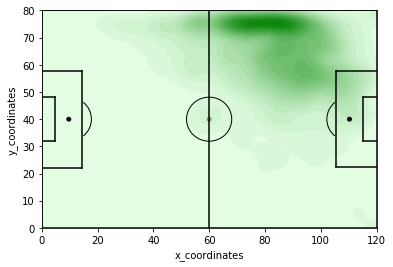

In [47]:
# fig=plt.figure() #set up the figures
fig, ax1 = plt.subplots(1, 1)
draw_pitch(ax1) #overlay our different objects on the pitch
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('on')
sns.kdeplot(barca[(barca['player_name']== 'Neymar da Silva Santos Junior') & (barca['period'] == 1)]['x_coordinates'],
            barca[(barca['player_name']== 'Neymar da Silva Santos Junior') & (barca['period'] == 1)]['y_coordinates'],
#             barca[(barca['player_name']== 'Lionel Andrés Messi Cuccittini') & (barca['period'] == 2)]['y_coordinates'], 
            shade = "True", n_levels = 30, color = 'green')
plt.show()



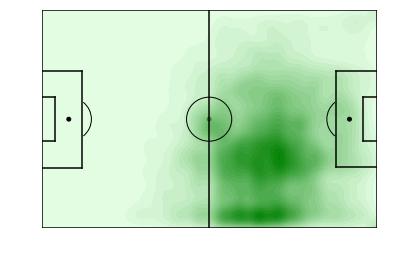

In [62]:
# fig=plt.figure() #set up the figures
fig, ax1 = plt.subplots(1, 1)
draw_pitch(ax1) #overlay our different objects on the pitch
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('off')
sns.kdeplot(barca[(barca['player_name']== 'Lionel Andrés Messi Cuccittini') & (barca['period'] == 1)]['x_coordinates'],
            barca[(barca['player_name']== 'Lionel Andrés Messi Cuccittini') & (barca['period'] == 1)]['y_coordinates'],
            shade = "True", n_levels = 30, color = 'green')
plt.savefig('./Neymar.png')
plt.show()

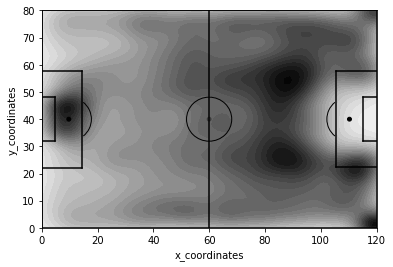

In [28]:
# fig=plt.figure() #set up the figures
fig, ax1 = plt.subplots(1, 1)
draw_pitch(ax1) #overlay our different objects on the pitch
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.axis('on')
# plt.scatter(barca[(barca['player_name']== 'Neymar da Silva Santos Junior') & (barca['period'] == 1)]['x_coordinates'],
#              barca[(barca['player_name']== 'Neymar da Silva Santos Junior') & (barca['period'] == 1)]['y_coordinates'], c = 'red')
sns.kdeplot(barca[(barca['pass_outcome_name']== 'Incomplete') & (barca['period'] == 1)]['x_coordinates'],
            barca[(barca['pass_outcome_name']== 'Incomplete') & (barca['period'] == 1)]['y_coordinates'],
#             barca[(barca['player_name']== 'Lionel Andrés Messi Cuccittini') & (barca['period'] == 2)]['y_coordinates'], 
            shade = "True", n_levels = 30, color = 'black')
plt.show()

In [29]:
barca[barca['player_name'] == 'Lionel Andrés Messi Cuccittini']['under_pressure'].value_counts()

0    47946
1    22755
Name: under_pressure, dtype: int64

In [30]:
list(barca.columns)

['id',
 'index',
 'period',
 'timestamp',
 'minute',
 'second',
 'possession',
 'duration',
 'related_events',
 'location',
 'under_pressure',
 'counterpress',
 'off_camera',
 'out',
 'type_name',
 'possession_team_name',
 'play_pattern_name',
 'team_name',
 'tactics_lineup',
 'tactics_formation',
 'player_name',
 'position_name',
 'pass_deflected',
 'pass_switch',
 'pass_shot_assist',
 'pass_cross',
 'pass_aerial_won',
 'pass_no_touch',
 'pass_miscommunication',
 'pass_length',
 'pass_straight',
 'pass_end_location',
 'pass_cut_back',
 'pass_inswinging',
 'pass_angle',
 'pass_outswinging',
 'pass_goal_assist',
 'pass_backheel',
 'pass_type_name',
 'pass_body_part_name',
 'pass_recipient_name',
 'pass_technique_name',
 'pass_height_name',
 'pass_outcome_name',
 'carry_end_location',
 'ball_receipt_outcome_name',
 'interception_outcome_name',
 'dribble_overrun',
 'dribble_nutmeg',
 'dribble_no_touch',
 'dribble_outcome_name',
 'goalkeeper_success_in_play',
 'goalkeeper_end_location',
 '

In [31]:
barca[(barca['pass_outcome_name']== 'Incomplete') & (barca['period'] == 1)]['location']

21          [3.9, 69.9]
22         [73.0, 13.5]
36          [77.7, 6.9]
56        [112.5, 20.4]
144        [45.0, 41.3]
              ...      
873315    [117.9, 23.5]
873341    [106.2, 59.1]
873368     [101.9, 6.5]
873373     [29.3, 50.0]
873388     [93.4, 57.5]
Name: location, Length: 15284, dtype: object

In [32]:
barca['pass_goal_assist'].value_counts()

0    874196
1       630
Name: pass_goal_assist, dtype: int64

## Preprocessing: `StandardScaler`

In [33]:
df = barca[(barca['pass_outcome_name']== 'Incomplete')][['x_coordinates', 'y_coordinates']]
df

,x_coordinates,y_coordinates
21,3.9,69.9
22,73.0,13.5
36,77.7,6.9
56,112.5,20.4
144,45.0,41.3
...,...,...
874753,26.3,80.0
874755,77.9,2.2
874757,37.0,68.5
874785,46.5,41.3


In [45]:
barca['y_coordinates'] = barca['y_coordinates'].astype(float)
barca['x_coordinates'] = barca['x_coordinates'].astype(float)

In [36]:
df['y_coordinates']

21        69.9
22        13.5
36         6.9
56        20.4
144       41.3
          ... 
874753    80.0
874755     2.2
874757    68.5
874785    41.3
874819    68.2
Name: y_coordinates, Length: 30168, dtype: float64

In [37]:
def invert_coor(val):
    if val == 40:
        return 40
    elif val != 40:
        init = val
        val += 80
        val -= 2*init
        return val
#     elif val > 40:
#         init = val
#         val += 80
#         val -= 2*init
#         print(val)

In [46]:
barca['y_coordinates'] = barca['y_coordinates'].apply(invert_coor)

In [ ]:
dictionary = {}
j = 0
for i in range(-80, 1):
    dictionary[j] = i
    j += 1
dictionary

In [ ]:
check(40)

In [ ]:
sns.scatterplot(df['x_coordinates'], df['y_coordinates'])

In [ ]:
ss = StandardScaler()
X_scaled = ss.fit_transform(df)

In [ ]:
dbscan = DBSCAN(eps=.5, min_samples=30)
dbscan.fit(df);

In [ ]:
silhouette_score(X_scaled, dbscan.labels_)

In [56]:
(set(list(barca['player_name'])))

{'Antonio Baltasar Doblas Santana',
 'Guilherme Oliveira Santos',
 'Hernán Darío Bernardello',
 'Mateo Pablo Musacchio',
 'Igor Gabilondo del Campo',
 'Andrés Lamas Bervejillo',
 'Jaime Jiménez Merlo',
 'Mathieu Berson',
 'Pedro López Muñoz',
 'Marc Fernández Gràcia',
 'Alberto Marcos Rey',
 'Achille Emaná Edzimbi',
 'Not Applicable',
 'Miguel Torres Gómez',
 'Rubén Rochina Naixes',
 'Jefferson Antonio Montero Vite',
 'Henok Goitom',
 'Jorge Pulido Mayoral',
 'Raúl Iznata Zabala',
 'Denis Cheryshev',
 'Natalio Lorenzo Poquet',
 'Diego Mainz García',
 'Mouhamadou Dabo',
 'Diego Daniel Colotto',
 'José Maria Gutiérrez Hernández',
 'Asier Goiria Etxebarria',
 'Alejandro Castro Fernández',
 'Eduardo Jesús Vargas Rojas',
 'Rafael van der Vaart',
 'Juan Pablo Carrizo',
 'José Izquierdo Martínez',
 'David Belenguer Reverter',
 'Enrique Sola Clemente',
 'Mikel González de Martín Martínez',
 'Christian Fernández Salas',
 'Danijel Pranjić',
 'Pablo Hernández Domínguez',
 'Fernando José Torres Sa

In [ ]:
player_ids = barca[['player_name', 'player_id']].values # this is a list of lists

